In [85]:
import scanpy as sc
import scib
import pandas as pd
import click
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata, re
from string import capwords
import seaborn as sns
from matplotlib import cm
from matplotlib import colors
import matplotlib as mpl
import sys,warnings
import anndata

mpl.rcParams['pdf.fonttype']  = 42
warnings.filterwarnings("ignore")
# sc.settings.set_figure_params(dpi=60, facecolor='white')
pd.set_option("display.max_rows", 40)
pd.set_option("display.precision", 2)


## 1. Load integrated data

In [ ]:
input_data = {
    "harmonyCCA":'../DATA/Developmental_lung_of_human_and_mouse.h5ad', #1
    "harmony": './results/harmony_integration.h5ad', #2
    "scanorama": '/./results/scanorama_integration.h5ad', #3
    "scANVI": './results/scANVI_integration.h5ad', #4
    "LIGER": './results/LIGER_integration.h5ad', #5
    "fastMNN": './results/fastMNN_integration.h5ad', #6
    "saturn":'./results/saturn_integration.h5ad', #7
    "seuratCCA": './results/seuratCCA_integration.h5ad', #8
    "seuratRPCA": './results/seuratRPCA_integration.h5ad'#9
}

In [100]:
layout_data = {}
for s in input_data:
    adata = sc.read(input_data[s])
    bdata = anndata.AnnData(obs = adata.obs, var = adata.var, obsm = adata.obsm)
    layout_data[s] = bdata

## 2. Set colors

In [102]:
for i in layout_data:
    if 'species' not in layout_data[i].obs.columns.tolist():
        layout_data[i].obs['species'] = np.array(layout_data[i].obs['dataset'])
        layout_data[i].obs['species'] = layout_data[i].obs['species'].replace({'Human': 'hsapiens', 'Mouse': 'mmusculus'})

    layout_data[i].obs['species'] = pd.Categorical(np.array(layout_data[i].obs['species']),['mmusculus', 'hsapiens'])
    layout_data[i].uns['species_colors'] = ['#F18E3D', '#5D7DB8']

    layout_data[i].obs['maincelltype'] = pd.Categorical(np.array(layout_data[i].obs['maincelltype']),['Epithelial cells', 'Mesenchymal cells', 'Endothelial cells'])
    layout_data[i].uns['maincelltype_colors'] = ['#A398C0', '#94B2B9', '#E96161']
    
    print(i, list(layout_data[i].obsm.keys()))

harmonyCCA ['X_cca', 'X_cca_harmony', 'X_pca', 'X_seurat', 'X_umap']
harmony ['X_cca', 'X_cca_harmony', 'X_pca', 'X_pca_harmony', 'X_umap', 'X_umapharmony', 'X_umapraw']
scanorama ['X_cca', 'X_cca_harmony', 'X_pca', 'X_scanorama', 'X_umap', 'X_umapraw', 'X_umapscanorama']
scANVI ['X_cca', 'X_cca_harmony', 'X_mde_scanvi', 'X_pca', 'X_scANVI', 'X_umap', 'X_umapscANVI']
LIGER ['X_cca', 'X_cca_harmony', 'X_inmf', 'X_pca', 'X_umap']
fastMNN ['X_mnn', 'X_umap']
saturn ['X_pca', 'X_saturn', 'X_umap', 'macrogenes']
seuratCCA ['X_pca', 'X_umap']
seuratRPCA ['X_pca', 'X_umap']


## 3. Plot layout

In [105]:
layout = {
    "harmonyCCA":'X_umap',
    "harmony": 'X_umapharmony', #2
    "scanorama": 'X_umapscanorama', #3
    "scANVI": 'X_umap', #4
    "LIGER": 'X_umap', #5
    "fastMNN": 'X_umap', #6
    "saturn":'X_umap', #7
    "seuratCCA": 'X_umap', #8
    "seuratRPCA": 'X_umap'#9
}

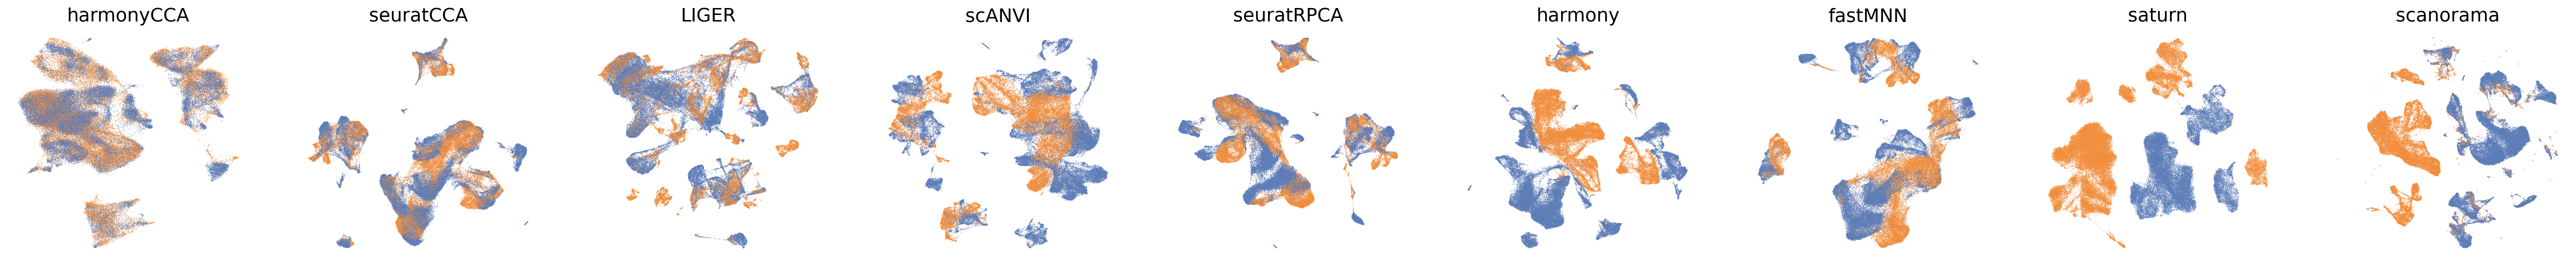

In [261]:
plt.rc('figure', figsize=[5, 5], dpi=150)
methods = ['harmonyCCA',  'seuratCCA','LIGER', 'scANVI', 'seuratRPCA','harmony', 'fastMNN', 'saturn', 'scanorama']
fig, axs = plt.subplots(1, 9, figsize=(44, 4))
for i in range(len(methods)):
    x = methods[i]
    layout_data[x].obs[x] = layout_data[x].obs['species']
    layout_data[x].uns['%s_colors'%x] = layout_data[x].uns['species_colors']
    np.random.seed(1)
    o=np.random.choice(np.arange(layout_data[x].shape[0]), layout_data[x].shape[0],replace = False)
    sc.pl.embedding(layout_data[x][o],basis = layout[x],color=[x],frameon=False,ax = axs[i],show=False)
    axs[i].legend_.remove()
plt.savefig('figures/UMAP-Species.png')

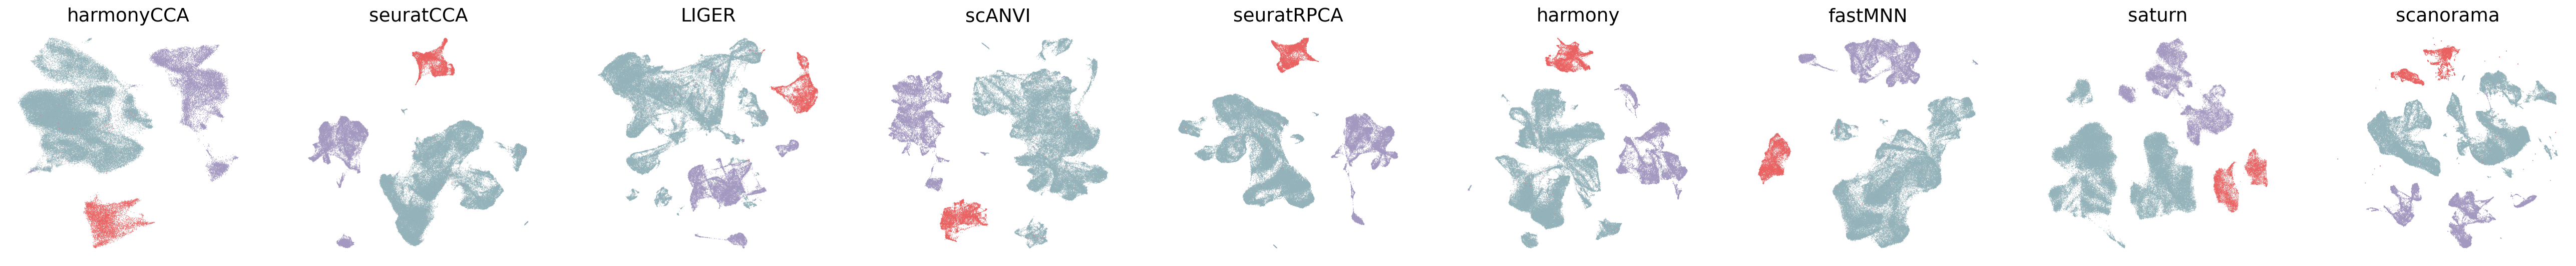

In [262]:
plt.rc('figure', figsize=[5, 5], dpi=150)
methods = ['harmonyCCA', 'seuratCCA', 'LIGER', 'scANVI', 'seuratRPCA','harmony', 'fastMNN', 'saturn', 'scanorama']
fig, axs = plt.subplots(1, 9, figsize=(44, 4))
for i in range(len(methods)):
    x = methods[i]
    layout_data[x].obs[x] = layout_data[x].obs['maincelltype']
    layout_data[x].uns['%s_colors'%x] = layout_data[x].uns['maincelltype_colors']
    np.random.seed(1)
    o=np.random.choice(np.arange(layout_data[x].shape[0]), layout_data[x].shape[0],replace = False)
    sc.pl.embedding(layout_data[x][o],basis = layout[x],color=[x],frameon=False,ax = axs[i],show=False)
    axs[i].legend_.remove()
plt.savefig('figures/UMAP-maincelltype.png')

## 4. Plot metrics

We evaluated different integration methods followed BENGAL pipeline (PMID: 37838716). This analysis uses two metrics to evaluate integration performance. The species mixing score indicates the mixture of mouse and human cells in integrated space. The biology conservation score reflects the discriminability of different cell types after integration, which is used to evaluate the presence of over-correction. Higher values for both scores represent better performance. Species mixing was assessed by 4 established batch correction metrics for scRNA-seq. This includes the principal component regression (PCR), batch average silhouette width (bASW), graph connectivity (GC) and k-nearest neighbour batch effect test (kBET). The scIB package was used to calculate the metrics (PMID: 34949812). All metrics were computed on the latent embedding resulted from integrated methods. We computed these 4 metrics in 9 integration strategies and 1 unintegrated data with homology genes. For each metric, we performed min-max scaling to reflect the relative performance of different strategies in concordance with scIB. We included the unintegrated data in the scaling as a reference, to avoid minor differences in metrics between algorithms that performed similarly well enlarged by scaling.

Species mixing score is the average of the scaled 4 metrics:

$$\text{Species mixing score}=\text{average}(\text{PCR}_{\text{scaled}}, \text{bASW}_{\text{scaled}}, \text{GC}_{\text{scaled}}, \text{KBET}_{\text{scaled}})$$


Biology conservation was assessed by 3 biology conservation metrics for scRNA-seq. Biology conservation metrics include cell type average silhouette width (cASW), normalised mutual information (NMI), and ARI. We computed these 4 metrics in 9 integration strategies and 1 unintegrated data with homology genes using scIB and perform min-max scaling. Biology conservation score is the average of the scaled metrics.
$$\text{Biology conservation score}=\text{average}(\text{cASW}_{\text{scaled}}, \text{NMI}_{\text{scaled}}, \text{ARI}_{\text{scaled}})$$


In [225]:
inte_metric = {}
unin_metric = {}
inte_basw = {}
unin_basw = {}
for x in layout.keys():
    inte_metric[x] = pd.read_csv('%s_scIB_integrated_metrics.csv'%x,index_col=0)
    unin_metric[x] = pd.read_csv('%s_scIB_orig_metrics.csv'%x,index_col=0)
    inte_basw[x] = pd.read_csv('%s_scIB_integrated_basw.csv'%x,index_col=0)
    unin_basw[x] = pd.read_csv('%s_scIB_orig_basw.csv'%x,index_col=0)

In [226]:
species_mixing_metric = ['PCR', 'bASW', 'GC', 'kBET']                     
biology_conservation_metric = ['NMI', 'ARI', 'cASW']

In [ ]:
score_inte = pd.concat([inte_metric[x] for x in inte_metric], ignore_index=True);score_inte['conditoin'] = 'integrated';score_inte = score_inte.drop(columns='iso_F1')
score_unin = pd.concat([unin_metric[x] for x in unin_metric], ignore_index=True);score_unin['conditoin'] = 'original';score_unin = score_unin.drop(columns='iso_F1')
score_unin = score_unin.iloc[[0],:]
score_unin.loc[0,'integration_method'] = 'unintegration'
score = pd.concat([score_inte,score_unin])
score_raw = score.copy()
score_raw = score_raw.loc[:,['integration_method','PCR', 'bASW', 'GC', 'kBET', 'NMI', 'ARI', 'cASW', 'species_key', 'batch_key', 'cluster_key',  'conditoin']]
# Scale to 0-1
for col in species_mixing_metric+biology_conservation_metric:
    min_val = score[col].min()
    max_val = score[col].max()
    score[col] = (score[col] - min_val) / (max_val - min_val)
score['PCR'] = 1-score['PCR'].values

In [228]:
score = score.loc[:,['integration_method','PCR', 'bASW', 'GC', 'kBET', 'NMI', 'ARI', 'cASW', 'species_key', 'batch_key', 'cluster_key',  'conditoin']]

In [230]:
species_mixing_score = score.loc[score['conditoin'] == 'integrated',species_mixing_metric].mean(1).values
biology_conservation_score = score.loc[score['conditoin'] == 'integrated',biology_conservation_metric].mean(1).values

In [231]:
score_scaled = pd.DataFrame({'integration_method':score_inte['integration_method'].values,'species_mixing_score':species_mixing_score, 'biology_conservation_score':biology_conservation_score,'species_key':'species','batch_key':'species','cluster_key':'maincelltype'})

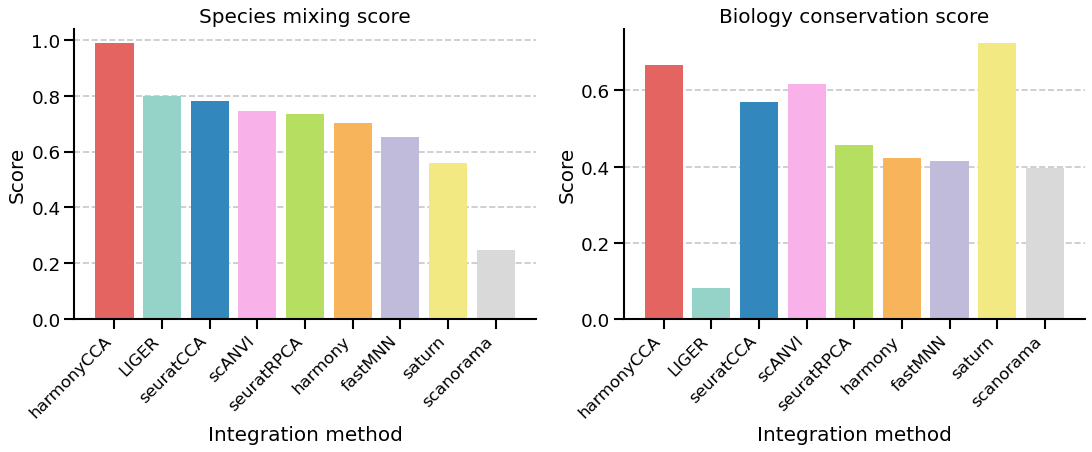

In [ ]:
df_sorted = score_scaled.sort_values('species_mixing_score', ascending=False)

methods = df_sorted['integration_method']
mixing_scores = df_sorted['species_mixing_score']
conservation_scores = df_sorted['biology_conservation_score']

colors = ['#E36460','#95D3C9','#3288BD','#F9B1EA','#B6DE61','#F8B45B','#C0BBDB','#F3E982','#D9D9D9']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# species_mixing_score
ax1.bar(methods, mixing_scores, color=colors, zorder=2)
ax1.set_title('Species mixing score')
ax1.set_xlabel('Integration method')
ax1.set_ylabel('Score')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=15)

# biology_conservation_score
ax2.bar(methods, conservation_scores, color=colors, zorder=2)
ax2.set_title('Biology conservation score')
ax2.set_xlabel('Integration method')
ax2.set_ylabel('Score')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=15)

for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

plt.tight_layout()
plt.savefig('figures/Integration_score.pdf')

## 5. Save score results

In [ ]:
with pd.ExcelWriter('figures/score.xlsx') as writer:
    score_raw.to_excel(writer, sheet_name='Raw score', index=False)
    score.to_excel(writer, sheet_name='Scaled score', index=False)
    score_scaled.to_excel(writer, sheet_name='Average score', index=False)